In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = torch.cat([x, out], 1)
        return out

In [3]:
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False) # 1x1 Conv ลด Channel
        self.pool = nn.AvgPool2d(2) # 2x2 AvgPool ลดขนาดภาพ

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = self.pool(out)
        return out

In [4]:
class DenseNet(nn.Module):
    def __init__(self, growth_rate=12, num_layers=4, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate
        
        # --- 1. Initial Convolution ---
        # สำหรับ CIFAR-10 ภาพเล็ก (32x32) เรามักใช้ 3x3 conv แทนที่จะเป็น 7x7 แบบ ImageNet
        num_channels = 2 * growth_rate 
        self.conv1 = nn.Conv2d(3, num_channels, kernel_size=3, padding=1, bias=False)

        # --- 2. Dense Block 1 ---
        self.block1 = self._make_dense_block(num_channels, num_layers)
        num_channels += num_layers * growth_rate
        
        # --- 3. Transition 1 ---
        out_channels = num_channels // 2 # ลด Channel ลงครึ่งหนึ่ง (Compression)
        self.trans1 = TransitionLayer(num_channels, out_channels)
        num_channels = out_channels

        # --- 4. Dense Block 2 ---
        self.block2 = self._make_dense_block(num_channels, num_layers)
        num_channels += num_layers * growth_rate
        
        # --- 5. Transition 2 ---
        out_channels = num_channels // 2
        self.trans2 = TransitionLayer(num_channels, out_channels)
        num_channels = out_channels

        # --- 6. Dense Block 3 (Block สุดท้าย) ---
        self.block3 = self._make_dense_block(num_channels, num_layers)
        num_channels += num_layers * growth_rate

        # --- 7. Classification Layer ---
        self.bn_final = nn.BatchNorm2d(num_channels)
        self.fc = nn.Linear(num_channels, num_classes)

    def _make_dense_block(self, in_channels, n_layers):
        layers = []
        for i in range(n_layers):
            layers.append(DenseLayer(in_channels + i * self.growth_rate, self.growth_rate))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)             # 32x32
        out = self.trans1(self.block1(out)) # 32x32 -> 16x16
        out = self.trans2(self.block2(out)) # 16x16 -> 8x8
        out = self.block3(out)          # 8x8
        
        out = F.relu(self.bn_final(out))
        out = F.adaptive_avg_pool2d(out, (1, 1)) # Global Average Pooling (เหลือ 1x1)
        out = out.view(out.size(0), -1)          # Flatten
        out = self.fc(out)
        return out

In [5]:
batch_size = 64
learning_rate = 0.001
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize RGB
])

In [7]:
# โหลด Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [8]:
def plot_training_results(train_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # กราฟที่ 1: Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-o', label='Training Loss')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # กราฟที่ 2: Test MSE
    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracies, 'r-o', label='Test MSE')
    plt.title('Test MSE over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MSE (%)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [9]:
print(f"Using device: {device}")
model = DenseNet(growth_rate=12, num_layers=6, num_classes=10).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

epoch_losses = []
epoch_test_losses = [] 

print("Start Training...")
for epoch in range(epochs):
    running_loss = 0.0
    
    # --- Training Phase ---
    model.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # [Same as before] Labels to One-Hot
        labels_one_hot = F.one_hot(labels, num_classes=10).float()

        optimizer.zero_grad()
        outputs = model(inputs)
        
        # [Same as before] Softmax before MSE
        outputs_prob = F.softmax(outputs, dim=1)
        
        loss = criterion(outputs_prob, labels_one_hot)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    avg_loss = running_loss / len(trainloader)
    epoch_losses.append(avg_loss)
    
    # --- Evaluation Phase (Modified for MSE) ---
    model.eval()
    test_running_loss = 0.0 # Variable to track Test MSE
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # --- [NEW Step] Must replicate training logic for Test MSE ---
            
            # 1. Convert Test Labels to One-Hot
            labels_one_hot = F.one_hot(labels, num_classes=10).float()
            
            # 2. Apply Softmax to outputs
            outputs_prob = F.softmax(outputs, dim=1)
            
            # 3. Calculate MSE Loss
            loss = criterion(outputs_prob, labels_one_hot)
            test_running_loss += loss.item()
    
    # Calculate Average Test MSE
    avg_test_mse = test_running_loss / len(testloader)
    epoch_test_losses.append(avg_test_mse)
    
    # Print both Train Loss and Test MSE
    print(f'Epoch [{epoch+1}/{epochs}] Train MSE: {avg_loss:.6f} | Test MSE: {avg_test_mse:.6f}')

print('Finished Training')

Using device: cuda
Start Training...
Epoch [1/10] Train MSE: 0.061926 | Test MSE: 0.051349
Epoch [2/10] Train MSE: 0.045859 | Test MSE: 0.048804
Epoch [3/10] Train MSE: 0.039414 | Test MSE: 0.042028
Epoch [4/10] Train MSE: 0.034349 | Test MSE: 0.044462
Epoch [5/10] Train MSE: 0.030652 | Test MSE: 0.036909
Epoch [6/10] Train MSE: 0.027538 | Test MSE: 0.030536
Epoch [7/10] Train MSE: 0.025393 | Test MSE: 0.027268
Epoch [8/10] Train MSE: 0.023612 | Test MSE: 0.030056
Epoch [9/10] Train MSE: 0.022021 | Test MSE: 0.026782
Epoch [10/10] Train MSE: 0.020835 | Test MSE: 0.027626
Finished Training


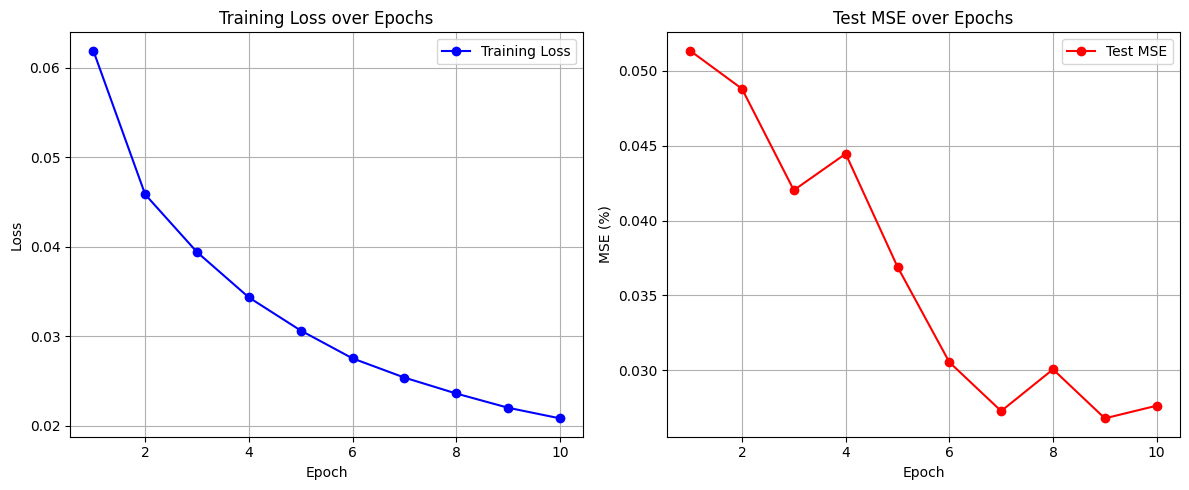

In [10]:
# 3. เรียกใช้ฟังก์ชันพล็อตกราฟ -- [UPDATE]
plot_training_results(epoch_losses, epoch_test_losses)